<a id='top'></a>

[1. SQL](#sql)<br>
[2. EDA](#eda)<br>
[3. Modeling](#modeling)<br>
[4. Production](#prod)<br>

In [ ]:
# References
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
# https://www.kaggle.com/amavuduru/exploratory-data-analysis-and-logistic-regression

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from pycaret import classification
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import pyodbc
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=10.27.251.83;'
                      'Database=OpenBook;'
                      'Trusted_Connection=yes;')

<a id='sql'></a>
# SQL Query
[Top](#top)<br>

In [28]:
# For training model, declare 4 prior terms. For production model, declare current term only and leave others blank
data_current = pd.read_sql_query("""\
declare @term1 varchar(50) = '2021fa'
declare @term2 varchar(50) = ''
declare @term3 varchar(50) = ''
declare @term4 varchar(50) = ''

select
	t1.[student id]
	, t1.Term [Start Term]
	, [GPA Institutional Term]
	, case when t2.[Student ID] is not null then 1 else 0 end [Retained]
	, case when ([start of term retention status] in ('new', 'transfer in') or [starting cohort term] = t1.term) then 1 else 0 end [new_student]
	, case when tests.[Student ID] is null then 0 else 1 end [ptest_exists]
	, max(aleks) aleks, max(sat_english) sat_english, max(sat_math) sat_math, max(act_composite) act_composite, max(cccrtw) cccrtw
	, case when max(count_tests) is null then 0 else max(count_tests) end count_tests
	, case when waiver.[Student ID] is null then 0 else 1 end test_waiver 
	, case when t1.[Home College] = 'DA' then 1 else 0 end [HC_DA]
	, case when t1.[Home College] = 'KK' then 1 else 0 end [HC_KK]
	, case when t1.[Home College] = 'MX' then 1 else 0 end [HC_MX]
	, case when t1.[Home College] = 'OH' then 1 else 0 end [HC_OH]
	, case when t1.[Home College] = 'TR' then 1 else 0 end [HC_TR]
	, case when t1.[Home College] = 'WR' then 1 else 0 end [HC_WR]
	, case when t1.[Home College] not in ('DA', 'HW', 'KK', 'MX', 'OH', 'TR', 'WR') then 1 else 0 end [HC_other]
	, [First_reg]
	, case when t1.[Gender] = 'Male' then 1 else 0 end [Gender_Male]
	, case when t1.[Gender] = '(Blank)' then 1 else 0  end [Gender_Unknown]
	, case when [Age at Census] is null then 0 else [age at census] end [age]
	, case when t1.[Ethnicity] = 'Black' then 1 else 0 end [Eth_Black]
	, case when t1.[Ethnicity] = 'Asian' then 1 else 0 end [Eth_Asian]
	, case when t1.[Ethnicity] = 'White' then 1 else 0 end [Eth_White]
	, case when t1.[Ethnicity] not in ('Black', 'Hispanic', 'White', 'Asian') then 1 else 0 end [Eth_Other]
	, case when t1.[STAR Eligibility] = 'STR' then 1 else 0 end [Star Status]
	, case when [Declared Degree] in ('AC', 'BC') then 1 else 0 end [Deg_cert]
	, case when [Declared Degree] in ('AAS', 'AGS') then 1 else 0 end [Deg_terminal]
	, case when [Full Or Part Time] = 'Full-Time' then 1 else 0 end [FT]
	, case when [Ever Early College] is null then 0 else 1 end [Ever Early College]
	, case when t1.[Athletic Indicator] = 'no' then 0 else 1 end [Athletic Indicator]
	, case when pelig.[Student ID] is null then 0 else 1 end [Pell Eligibility Status]
--	, case when pell_recipient_status = 'Pell Recipient' then 1 else 0 end [pell recipient status]

from
	openbook.dbo.pvt_studentterms t1
	
left join /*Exclude completers*/
(select distinct [Student ID], [Term Order]
from openbook.dbo.pvt_studentdegrees) 
degree on t1.[Student ID] = degree.[Student ID] and t1.[Term Order] = degree.[Term Order]

left join /*Check subsequent term enrollment*/
(select [Student ID], [Term Order], term
from openbook.dbo.pvt_StudentTerms
where Enrolled = 'yes' and [Instructional Area] = 'Semester Credit')
t2 on t1.[Student ID] = t2.[Student ID] and t1.[Term Order] = (t2.[Term Order] - 1)

/*Registration Date*/
left join
(select colleagueid, term, min([first_reg]) [First_reg] from (
	(select colleagueid, term, datediff(day, startDate, statusdate) [First_reg] from openbook.dbo.tbl_dropadd da
		left join (select  classsection, startdate from openbook.dbo.tbl_classsections) sd on da.classSection = sd.classSection
	where [status] = 'E' and academicLevel = 'cred' group by [colleagueId], term, startdate, statusdate)) reg2
group by colleagueid, term)
reg on t1.[student id] = reg.colleagueid and t1.term = reg.term

/*Early College*/
left join
(select distinct [student id], [Ever Early College] = 'Was EC' from openbook.dbo.pvt_studentterms where [enrolled] = 'yes' and [Early College] = 'yes') 
ec on t1.[Student ID] = ec.[Student id]

/*Placement test scores and count of tests*/
left join
(select [student id], [SAT - New - Evidence Based Read & Writing] sat_english, [SAT - New - Math Section Score SAT] sat_math, [CCCRTW - Writing] cccrtw
	, [ACT - Composite] act_composite, [ALEKS PPL - Math] aleks, count_tests, [term taken order]
from  
	(select [student id], test, [high score], [term taken order], row_number() over (partition by [student id] order by [term taken order]) count_tests
	from openbook.dbo.pvt_studenttests
	where [test] in ('CCCRTW - Writing', 'ACT - Composite', 'ALEKS PPL - Math') or ([test category] in ('sat') and [high score] >=100))
	sourcetable
	PIVOT
	(max([high score])
	for test IN ([SAT - New - Evidence Based Read & Writing], [SAT - New - Math Section Score SAT], [CCCRTW - Writing], [ACT - Composite], [ALEKS PPL - Math])) pivottable) 
tests on t1.[student id] = tests.[Student ID] and t1.[Term Order] >= tests.[term taken order]

/*Placement test waiver*/
left join
(select [student id], min([term taken order]) [term taken order] from openbook.dbo.pvt_studenttests 
where [test category] = 'placement test waiver' group by [student id])-- and concat(left(@term1, 4), 02) >= [term taken order])
waiver on t1.[student id] = waiver.[Student ID] and t1.[term order] >= waiver.[term taken order]

/*Student Financials: Pell eligible, Pell recipient, checklist items, DEL holds*/
left join
(select distinct [Student ID], [Financial Aid Federal ID], [Financial Aid Year]
from [Openbook].[dbo].[pvt_StudentFinancialAids] 
where  [Financial Aid Federal ID] = 'PELL' and [financial aid pell candidacy] = 'yes') 
pelig on t1.[Student ID] = pelig.[student id] and left(t1.Term, 4) = pelig.[financial aid year] - 1

where
	t1.Term in (@term1, @term2, @term3, @term4)
	and Enrolled = 'yes' and [Instructional Area] = 'semester credit' 
	and degree.[Student ID] is null and [Early College] = 'no' and [declared degree] not in ('na')
group by t1.[student id], t2.[Student ID], [start of term retention status], tests.[Student ID], waiver.[Student ID], t1.Term, t1.[Home College]
	, [First_reg], t1.[Gender], [age at census], t1.Ethnicity, t1.[STAR Eligibility], [Declared Degree], [Full or Part Time], [Ever Early College]
	, t1.[Athletic Indicator], pelig.[Student ID], [Starting Cohort Term], [GPA Institutional Term]
order by [student id], [Start Term]

""", conn)

data_current = pd.DataFrame(data_current)
data_current.shape

(20175, 35)

<a id='eda'></a>

# EDA
[Top](#top)<br>

In [ ]:
# Variables to test include:

# new or continuing student
# placement tests
# waived out of placement test
# home college (DA, KK, MX, OH, TR, WR, other, ref = HW)
# first reg date
# gender (male, other, ref = female)
# age
# ethnicity (black, asian, white, other, ref = hispanic)
# star status (free tuition)
# degree (certificate, terminal, coursetaker, ref=transfer)
# full time status
# ever early college
# athletic indicator
# pell eligibility status

In [11]:
data_current.describe()

,GPA Institutional Term,Retained,new_student,ptest_exists,aleks,sat_english,sat_math,act_composite,cccrtw,count_tests,...,Eth_Asian,Eth_White,Eth_Other,Star Status,Deg_cert,Deg_terminal,FT,Ever Early College,Athletic Indicator,Pell Eligibility Status
count,83554.000000,94619.000000,94619.000000,94619.000000,54733.000000,9210.000000,9139.000000,18494.000000,42588.000000,94619.000000,...,94619.000000,94619.000000,94619.000000,94619.000000,94619.000000,94619.000000,94619.000000,94619.000000,94619.000000,94619.000000
mean,2.579168,0.692874,0.314229,0.732052,40.329746,496.663409,488.610351,18.343625,4.431396,1.781714,...,0.058540,0.117619,0.030385,0.138725,0.019468,0.350152,0.519166,0.094294,0.011245,0.513861
std,1.193874,0.461305,0.464210,0.442893,22.398790,82.341511,86.729537,3.853669,1.546395,1.564111,...,0.234763,0.322158,0.171645,0.345661,0.138162,0.477020,0.499635,0.292239,0.105446,0.499810
min,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000,200.000000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,24.000000,430.000000,430.000000,15.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,0.000000,1.000000,37.000000,500.000000,490.000000,18.000000,5.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.500000,1.000000,1.000000,1.000000,57.000000,560.000000,540.000000,21.000000,6.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,4.000000,1.000000,1.000000,1.000000,100.000000,770.000000,800.000000,35.000000,6.000000,14.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# see which variables might show large variation between retained/not retained
data_current.groupby('Retained').mean()

,GPA Institutional Term,new_student,ptest_exists,aleks,sat_english,sat_math,act_composite,cccrtw,count_tests,test_waiver,...,Eth_Asian,Eth_White,Eth_Other,Star Status,Deg_cert,Deg_terminal,FT,Ever Early College,Athletic Indicator,Pell Eligibility Status
Retained,,,,,,,,,,,,,,,,,,,,,
0,1.833557,0.313421,0.677288,35.764759,482.813175,472.100109,17.827967,4.220944,1.559429,0.068100,...,0.042567,0.111493,0.031039,0.049553,0.020750,0.366001,0.399243,0.076050,0.007708,0.405575
1,2.838344,0.314587,0.756326,42.155251,500.149497,492.766744,18.542960,4.521838,1.880245,0.070471,...,0.065620,0.120334,0.030095,0.178252,0.018899,0.343126,0.572324,0.102381,0.012813,0.561860


<AxesSubplot:>

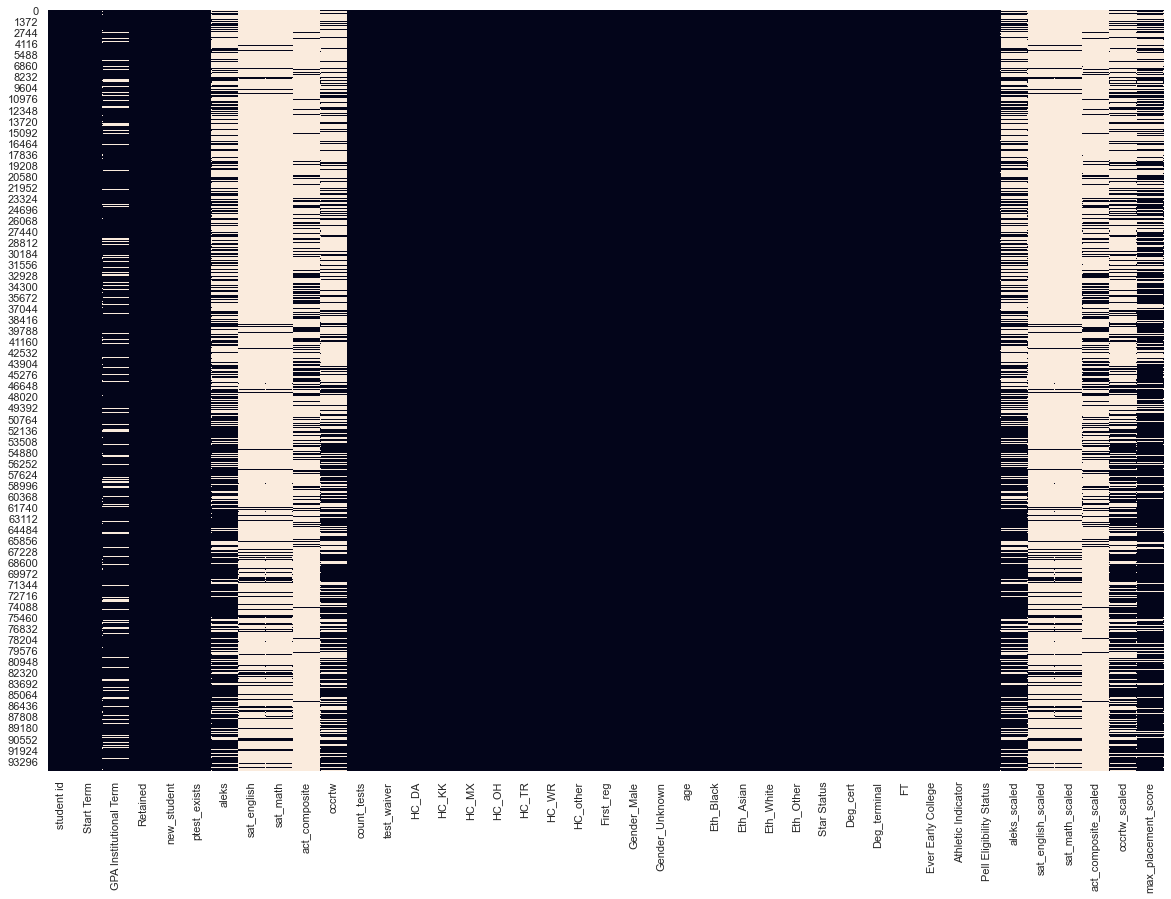

In [13]:
# check for null values
plt.figure(figsize=(20,14))
sns.heatmap(data_scaled.isnull(), cbar = False)

<AxesSubplot:xlabel='Retained', ylabel='count'>

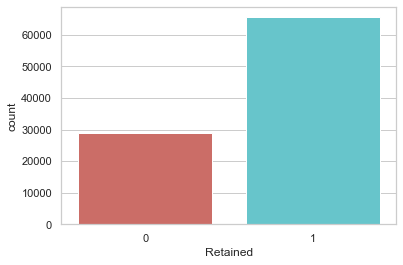

In [19]:
# Visualize retained/not retained 
sns.countplot(x='Retained',data=data_current, palette='hls')

<AxesSubplot:xlabel='count_tests', ylabel='Count'>

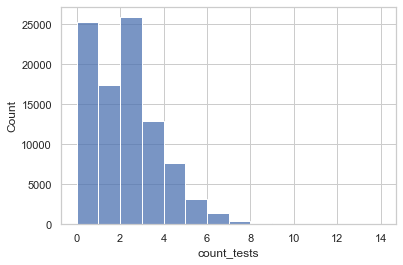

In [15]:
# view distribution for different numeric variables
sns.histplot(data = data_current, x='count_tests', binwidth = 1)

<AxesSubplot:xlabel='ptest_exists', ylabel='count'>

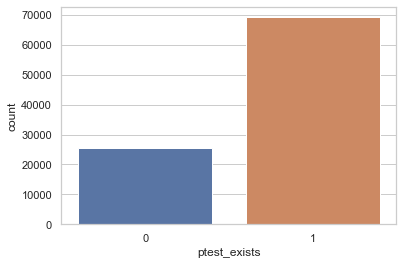

In [17]:
# view counts for categorical variables
sns.countplot(x = 'ptest_exists', data = data_current)

<AxesSubplot:>

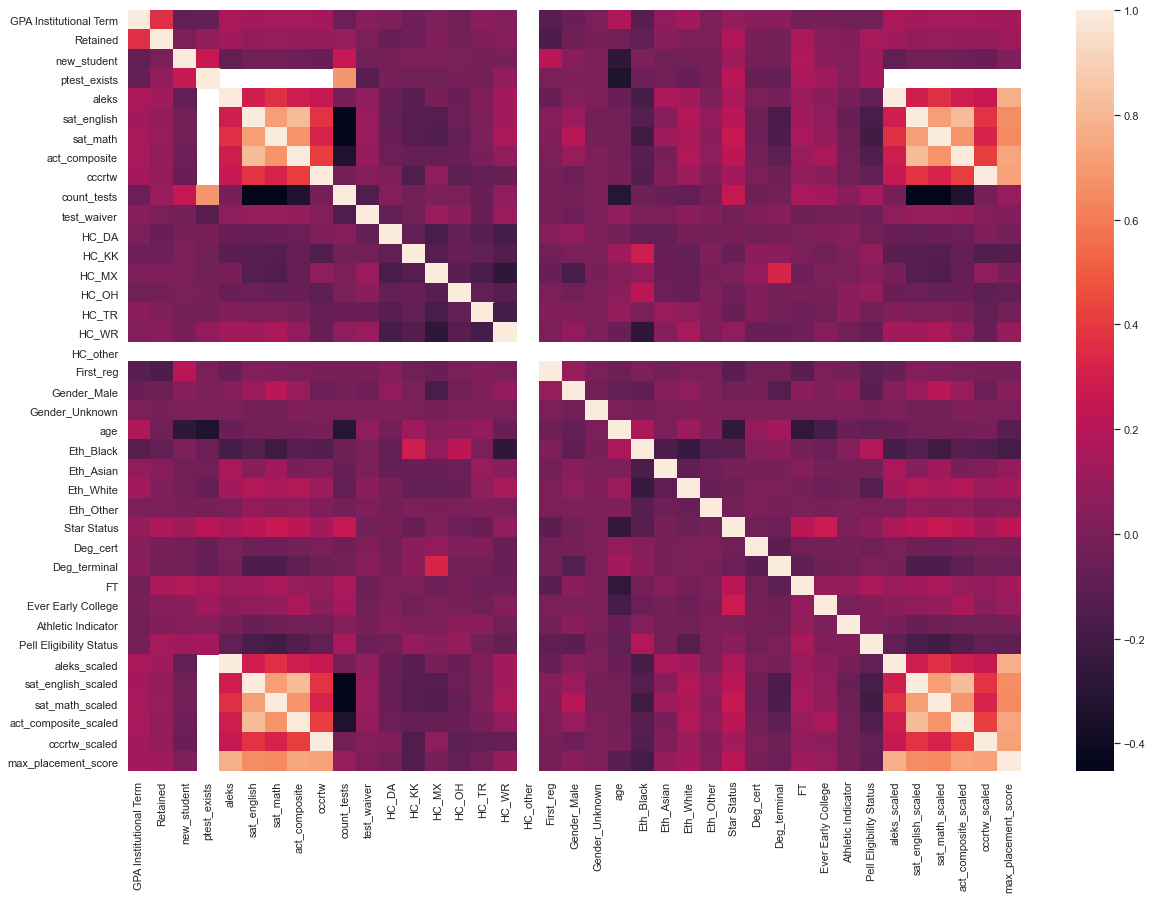

In [22]:
# Visualize correlations between data
plt.figure(figsize=(20,14))
sns.heatmap(data_scaled.corr())

<AxesSubplot:xlabel='max_placement_score', ylabel='GPA Institutional Term'>

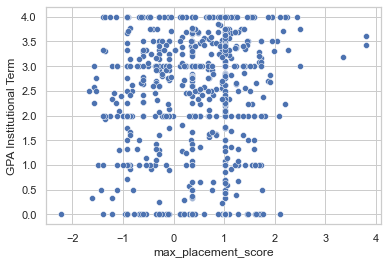

In [23]:
# Feature engineering placement tests to get normalized highest placement test score
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(data_current[['aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw']])
sc_X = pd.DataFrame(data=sc_X, columns=['aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled'])
data_scaled = pd.concat([data_current, sc_X], axis = 1)
data_scaled['max_placement_score'] = data_scaled[['aleks_scaled','sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled']].max(axis=1)

# For training data - wanted to see relationship between placement test score (scaled) and term GPA
sampledf = data_scaled.sample(n=1000)
sns.scatterplot(x = sampledf['max_placement_score'], y = sampledf['GPA Institutional Term'])

<a id='modeling'></a>

# Modeling
[Top](#top)<br>

In [4]:
# Notes on pycaret classification modeling:
# data split into train/test set
# numeric/categorical features inferred (should have been correctly set up by SQL query)
# 10 fold cross validation used
# numeric imputation done using mean value, categorical done using mode
# 70/30 imbalanced data set corrected via SMOTE

from pycaret.classification import *
classification_setup = classification.setup(data= data_scaled, target='Retained',
                                            ignore_features = ['student id', 'Start Term', 'GPA Institutional Term',
                                                           'aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw',
                                                           'aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 
                                                            'act_composite_scaled', 'cccrtw_scaled'])

,Description,Value
0,session_id,5106
1,Target,Retained
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(94619, 41)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,24
8,Ordinal Features,False
9,High Cardinality Features,False


In [6]:
# tests different sklearn classification models to determine high performers
classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7167,0.7092,0.9348,0.7304,0.8200,0.1992,0.2379,0.6680
gbc,Gradient Boosting Classifier,0.7155,0.7071,0.9476,0.7249,0.8214,0.1790,0.2264,7.1130
ada,Ada Boost Classifier,0.7106,0.6989,0.9318,0.7264,0.8164,0.1803,0.2164,1.9200
lr,Logistic Regression,0.7083,0.6971,0.9338,0.7239,0.8156,0.1694,0.2061,6.0710
lda,Linear Discriminant Analysis,0.7079,0.6961,0.9357,0.7229,0.8156,0.1654,0.2031,0.6280
ridge,Ridge Classifier,0.7059,0.0000,0.9538,0.7152,0.8175,0.1342,0.1824,0.1230
rf,Random Forest Classifier,0.6911,0.6681,0.8643,0.7350,0.7944,0.1895,0.2000,7.0470
et,Extra Trees Classifier,0.6735,0.6432,0.8188,0.7373,0.7759,0.1803,0.1838,12.1070
knn,K Neighbors Classifier,0.6625,0.6045,0.8258,0.7241,0.7716,0.1356,0.1400,2.1800
svm,SVM - Linear Kernel,0.6251,0.0000,0.7291,0.7433,0.6832,0.1320,0.1688,2.4270


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5106, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
# use highest performer
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7112,0.7055,0.9329,0.7265,0.8169,0.1811,0.2179
1,0.7121,0.7097,0.9318,0.7277,0.8172,0.1858,0.2221
2,0.7189,0.7053,0.9368,0.7315,0.8215,0.2049,0.2450
3,0.7133,0.7092,0.9311,0.7289,0.8177,0.1911,0.2271
4,0.7272,0.7207,0.9425,0.7362,0.8267,0.2287,0.2732
5,0.7167,0.7140,0.9357,0.7301,0.8202,0.1984,0.2376
6,0.7155,0.6987,0.9364,0.7289,0.8197,0.1931,0.2327
7,0.7170,0.7078,0.9313,0.7319,0.8197,0.2047,0.2412
8,0.7148,0.7018,0.9331,0.7294,0.8188,0.1943,0.2317
9,0.7202,0.7196,0.9366,0.7326,0.8222,0.2101,0.2502


In [26]:
# create final model to be used on current term data
final_model = finalize_model(lightgbm)

In [27]:
# review model metrics
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

<a id='prod'></a>

# Production model for current term
[Top](#top)<br>

#### BEFORE RUNNING CODE BELOW - edit original SQL query to be current term only
[SQL Query](#sql)<br>

In [31]:
# feature engineering placement tests to get normalized highest placement test score
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(data_current[['aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw']])
sc_X = pd.DataFrame(data=sc_X, columns=['aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled'])
data_scaled = pd.concat([data_current, sc_X], axis = 1)
data_scaled['max_placement_score'] = data_scaled[['aleks_scaled','sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled']].max(axis=1)

In [88]:
# run model on current data
current_set = predict_model(final_model, raw_score = True, data = data_scaled)
current_set.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(display=None, ml_usecase=MLUsecase.CLASSIFICATION, verbose=True, round=4, raw_score=True, encoded_labels=False, probability_threshold=None, estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5106, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0))
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,student id,Start Term,GPA Institutional Term,Retained,new_student,ptest_exists,aleks,sat_english,sat_math,act_composite,...,Pell Eligibility Status,aleks_scaled,sat_english_scaled,sat_math_scaled,act_composite_scaled,cccrtw_scaled,max_placement_score,Label,Score_0,Score_1
0,000007325,2021FA,None,0,0,0,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.4039,0.5961
1,000008994,2021FA,None,0,0,0,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.3952,0.6048
2,000011553,2021FA,None,0,0,0,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.4481,0.5519
3,000012367,2021FA,None,0,0,0,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.6480,0.3520
4,000014570,2021FA,None,0,0,0,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.6510,0.3490


<AxesSubplot:xlabel='Score_1', ylabel='Count'>

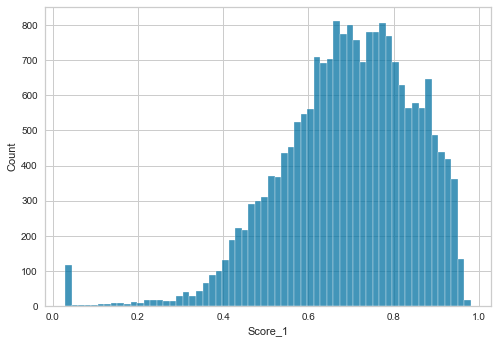

In [91]:
# visualize current term distribution of scores
sns.histplot(data = current_set, x='Score_1')

In [39]:
# insert into SQL to update report for Tableau dashboard and end users
import pyodbc
conn_ds = pyodbc.connect('Driver={SQL Server};'
                      'Server=10.27.251.83;'
                      'Database=DecisionSupport;'
                      'Trusted_Connection=yes;')
cursor = conn_ds.cursor()
# delete old data
cursor.execute("delete from decisionsupport.dbo.[retention scores 2021FA]")

# insert Dataframe into SQL Server:
for index, row in current_set[['student id', 'Score_1']].iterrows():
    cursor.execute("""\
    insert into decisionsupport.dbo.[retention scores 2021FA] ([Student_ID], Retention_Score) values(?, ?)"""
                   , row[0], row.Score_1 * 100)
conn_ds.commit()
cursor.close()